## Configuración: Importando paquetes

In [ ]:
import boto3
import pandas as pd
import os
import uuid
import matplotlib.pyplot as plt
import random
from matplotlib.pylab import imread, imshow
from PIL import Image

In [ ]:
LOCAL_PATH = '/home/ec2-user/SageMaker/'
LOCAL_IMAGE_PATH = '/home/ec2-user/SageMaker/images/'

In [ ]:
BUCKET_NAME = 'labstack-prewarm-8242fc2b-4780-436f-8c-readimages-1ebia9hs9angm'
REGION = 'ap-southeast-2'

In [ ]:
def submit_your_answer(results_df, task_file_name, task_answer):
    results_df.loc[task_answer].to_json(os.path.join(LOCAL_PATH, task_file_name))
    s3 = boto3.client('s3')
    s3.upload_file(Bucket=BUCKET_NAME, Filename=os.path.join(LOCAL_PATH, task_file_name), Key=task_file_name)


In [ ]:
def plot_image(image_key, image_title=''):     
    plt.figure(figsize=(12, 10))
    image = imread(os.path.join(LOCAL_IMAGE_PATH, image_key))
    plt.imshow(image)
    plt.axis('off')
    plt.title('{}: {}'.format(image_key, image_title))
    plt.show()    

### Obteniendo las imagenes de S3

In [ ]:
s3 = boto3.client('s3')
image_keys = []
resp = s3.list_objects_v2(Bucket=BUCKET_NAME)
for obj in resp['Contents']:
    if obj['Key'][-4:] == '.jpg':
        image_keys.append(obj['Key'])
print('Number of images: {}'.format(len(image_keys)))

Number of images: 94


### Creando un DataFrame para los resultados

In [ ]:
cols = ['bucket_name',
        'image_key',
        'text_in_image',
        'dominant_language_code',
        'dominant_language_score',
        'sentiment',
        'sentiment_positive_score', 
        'sentiment_negative_score', 
        'sentiment_neutral_score', 
        'sentiment_mixed_score',
        'n_faces',
        'label',
        'label_conf']

results_df = pd.DataFrame(index=image_keys, columns=cols)
results_df['bucket_name'] = BUCKET_NAME
results_df['image_key'] = image_keys

In [ ]:
results_df.head()

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,102.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,103.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,104.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Revisando imagenes aleatoriamente
El siguiente código muestra de forma aleatoria 10 imagenes contenidas en el bucket

In [ ]:
def display_images(image_keys, n_row=5, n_col=2):
    '''Display sample of images stored locally
       Arguments:
           image_keys (list): List of image keys 
           n_row (int): Number of rows in the image display
           n_col (int): Number of columns in the image display
    '''
    n_sample_images = n_row * n_col
    figure, ax = plt.subplots(nrows=n_row, ncols=n_col)
    figure.set_size_inches(10, 12)
    for ind in range(n_sample_images):
        ii = random.randrange(len(image_keys))
        image = imread(os.path.join(LOCAL_IMAGE_PATH, image_keys[ii]))
        ax.ravel()[ind].imshow(image)
        ax.ravel()[ind].set_axis_off()
        ax.ravel()[ind].set_title(image_keys[ii])

    plt.tight_layout()
    plt.show()


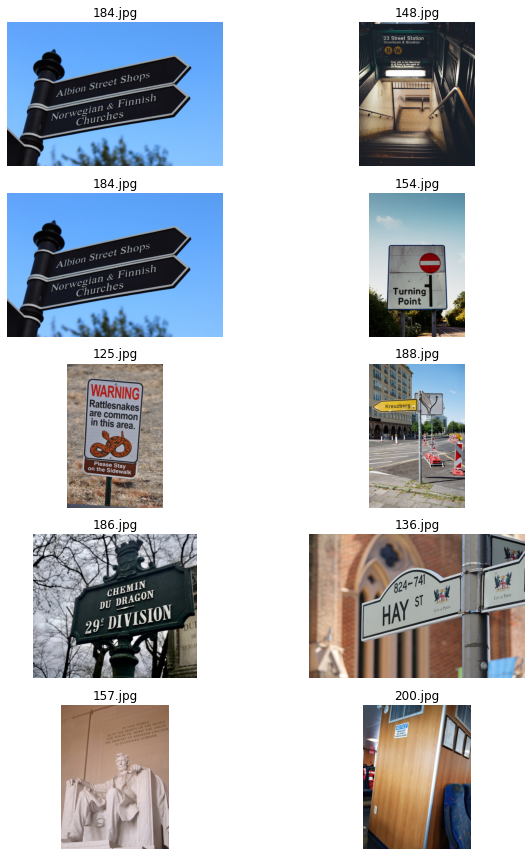

In [ ]:
display_images(image_keys, n_row=5, n_col=2)

#Tarea 1, paso 1: Definir una función para extraer el texto de una imagen

In [ ]:
def extract_text_from_image(bucket_name, image_key):

    client=boto3.client('rekognition')
    response=client.detect_text(Image={'S3Object':{'Bucket':bucket_name,'Name':image_key}})
    textDetections=response['TextDetections']
    text_tokens = []
    for i in range(len(textDetections)):
        if textDetections[i]['Type']=='LINE':
            text_tokens.append(textDetections[i]['DetectedText'])
    text = ' '.join(text_tokens) 
    return(text.lower())

### Ejemplo para extraer el texto en una imagen

In [ ]:
# Ejemplo para extraer el texto en una imagen
sample_image = '180.jpg'
text = extract_text_from_image(BUCKET_NAME, sample_image)
print('Automatically extracted text: {}'.format(text))
plot_image(sample_image, image_title=text)


### Tarea 1, paso 2: Rellenar la columna 'text_in_image' del marco de datos

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text in the image
    text_in_image = extract_text_from_image(BUCKET_NAME, key)
    results_df.loc[key, 'text_in_image'] = text_in_image

processing image: 100.jpg
["AUX HERDS OF LARMEE D'ORIENT ET DES TERRES LOINTAINES"]
processing image: 101.jpg
['HOME']
processing image: 102.jpg
['you are', 'beautiful']
processing image: 103.jpg
['ALL ARE', 'WELCOME', 'HERE.', 'consentle']
processing image: 104.jpg
['@@@@@@@@@@?', 'Work Hard', 'Stay Humble', '$ M W 1 F', 'NOV', 'I 2 3', '18 4 s 6 7 8', '10', '9', '14 15 16 17', '11 12 13', '18 19 20 21 22 23 24', '25 26 27 28 29 30', 'S instanote']
processing image: 105.jpg
['PLEASE BE', 'KIND TO', 'EACH OTHER']
processing image: 106.jpg
['MOURN OUR', 'LOSS', 'WE', '1929', '1968', 'DR.', 'MARTIN LUTHER', 'KING']
processing image: 107.jpg
['CREATIVITY', 'EXPRESS YOURSELF']
processing image: 108.jpg
['Please', 'help', 'by keeping a safe', 'of 6 feet', 'distance', 'Thank you for', 'social distancing']
processing image: 109.jpg
['steady', 'EDDY']
processing image: 110.jpg
['Widerrechtlich abgestellte', 'Fahrzeuge werden', 'kostenpflichtig abgeschleppt']
processing image: 111.jpg
['PLEASE 

###  Tarea 1, paso 3: Busque la imagen que contiene la palabra 'Lincoln' y envíe su respuesta

In [ ]:
for index, row in results_df.iterrows():
    if 'lincoln' in row['text_in_image'].lower():
        print(index)

157.jpg


In [ ]:
task1_answer = '157.jpg'
plot_image(task1_answer, image_title='')

In [ ]:
# DON'T CHANGE THIS LINE OR YOUR SUBMISSION FAILS
submit_your_answer(results_df, 'task1_res.json', task1_answer)

##Tarea 2: Detece el idioma dominante

Su gerente está contento con su progreso, pero le dice que algunas de las imágenes contienen otros idiomas además del inglés.
Es importante saber cuáles, ya que afecta la selección de imágenes. Entonces, se pregunta si es posible detectar el idioma dominante automáticamente.

Tu tarea es, en primer lugar, encontrar el lenguaje dominante en el texto de todas las imágenes. De todas las imágenes que contienen texto en alemán (no todas las imágenes),
cuál tiene la puntuación más alta de confianza en el idioma dominante. Para hacer esto, va a aprovechar la API detect_dominant_language de
Servicio Amazon Comprehend AI.

### Paso 1
Completa la función "extract_dominant_language"

### Paso 2:
Ejecute la función "extract_dominant_language" que acaba de completar en el texto de todas las imágenes.

### Paso 3
Encuentre la imagen con el puntaje de confianza más alto entre las que contienen texto en alemán y envíe su respuesta

### Tarea 2 paso 1- Función para detectar el lenguaje dominante.

In [ ]:
def extract_dominant_language(text):
    client_len = boto3.client('comprehend')
    response = client_len.detect_dominant_language(Text=text)
    dominant_language_code = response['Languages'][0]['LanguageCode']
    dominant_language_score = response['Languages'][0]['Score']
    return dominant_language_code, dominant_language_score

In [ ]:
extract_dominant_language('I am learning AWS AI services')

('en', 0.9271045327186584)

### Tarea 2 paso 2: Rellene las columnas 'dominante_language_code' y 'dominante_language_score' del marco de datos
Ejecute la siguiente celda una vez que haya completado "extract_dominant_language".  Se extraerá el idioma dominante y la puntuación de confianza de la columna 'text_in_image' de 'results_df' y se completará las columnas 'dominante_language_code' y 'dominante_language_score'.
Tenga en cuenta que en algunos casos no es posible extraer el idioma dominante (tal vez no haya suficiente texto). ¡No se preocupe si ve esos casos!

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    results_df.loc[key, 'text_in_image'] = text_in_image
    try: 
        dominant_language_code, dominant_language_score = extract_dominant_language(text_in_image)
        results_df.loc[key, 'dominant_language_code'] = dominant_language_code
        results_df.loc[key, 'dominant_language_score'] = round(dominant_language_score, 2)
    except:
        print('dominant language extraction  failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
dominant language extraction  failed
processing image: 118.jpg
processing image: 119.jpg
dominant language extraction  failed
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
dominant language extraction  failed
processing image: 139.jpg
domin

In [ ]:
results_df.head()

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,aux herds of larmee d'orient et des terres loi...,fr,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,home,en,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,102.jpg,you are beautiful,en,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,103.jpg,all are welcome here. consentle,en,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,104.jpg,@@@@@@@@@@? work hard stay humble $ m w 1 f no...,en,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tarea 2 Paso 3: Encuentra la imagen con el puntaje de confianza más alto entre las que contienen texto en alemán 
De todas las imágenes con texto en alemán (código de idioma: 'de'), ¿cuál tiene el 'puntaje_de_language_dominante' más alto?

In [ ]:
results_df[results_df.dominant_language_code=='de']

In [ ]:
task2_answer = '145.jpg'
print('Text: {}'.format(results_df.loc[task2_answer, 'text_in_image']))
print('Dominant Language: {}'.format(results_df.loc[task2_answer, 'dominant_language_code']))
print('Dominant Language Confidence: {}'.format(results_df.loc[task2_answer, 'dominant_language_score']))
plot_image(task2_answer, image_title='')

In [ ]:
submit_your_answer(results_df, 'task2_res.json', task2_answer)

Tarea 3: Análisis de sentimiento

Se pregunta si puede realizar un análisis de opinión automatizado y enriquecer aún más los metadatos de la imagen. Para hacer esto, va a aprovechar la API 'detect_sentiment' del servicio Amazon Comprehend AI. Más sobre la API 'detect_sentiment'

Su tarea es extraer el sentimiento y las puntuaciones asociadas del texto que se encuentra en cada una de las imágenes, y
encuentre la imagen con más sentimiento negativo entre aquellas con texto en inglés.


### Tarea 3 paso 1- Función de análisis
Complete 'sentiment_detection' function: This function uses Amazon Comprehend 'detect_sentiment' API to extract text sentiment. Extract both the sentiment and sentiment_scores for each of the [POSITIVE | NEGATIVE | NEUTRAL | MIXED] sentiment possibilities. The portion of the function you write shouldn't be more than a few lines of code. First call Amazon Comprehend 'detect_sentiment' and get a raw response. Analyze the response and make see how you can extract both sentiment and sentiment score. sentiment_score is going to be a Python dictionary. You can complete this is less than 5 lines of code!

In [ ]:
def sentiment_detection(text, language_code):
    client_sent = boto3.client('comprehend')
    response = client_sent.detect_sentiment(Text=text, LanguageCode=language_code)
    sentiment = response['Sentiment']#Extract from API response
    sentiment_scores = response['SentimentScore']# Extract from API response (a Python Dictionary
    return sentiment, sentiment_scores

In [ ]:
## Sample test for the function
sentiment_detection('Today is a fantastic day', 'en')

('POSITIVE',
 {'Positive': 0.9974599480628967,
  'Negative': 0.00018005631864070892,
  'Neutral': 0.0019463356584310532,
  'Mixed': 0.0004137237265240401})

## Tarea 3 Paso 2: Complete las columnas 'sentimiento' y 'sentiment_score' del marco de datos
Ejecutemos la función 'sentiment_detection' en el texto de todas las imágenes. Extraerá el sentimiento y verá las puntuaciones de sentimiento de la columna 'text_in_image' de 'results_df' y completará las columnas 'sentiment' y cuatro 'sentiment_score'. Tenga en cuenta que en algunos casos no es posible extraer la opinión (tal vez no hay suficiente texto) por lo que falla (¡y está bien!). ¡No se preocupe si ve esos casos!

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    try: 
        sentiment, sentiment_scores = sentiment_detection(text_in_image, row['dominant_language_code'])
        results_df.loc[key, 'sentiment'] = sentiment
        results_df.loc[key, 'sentiment_positive_score'] = round(sentiment_scores['Positive'], 2)
        results_df.loc[key, 'sentiment_negative_score'] = round(sentiment_scores['Negative'], 2)
        results_df.loc[key, 'sentiment_neutral_score'] = round(sentiment_scores['Neutral'], 2)
        results_df.loc[key, 'sentiment_mixed_score'] = round(sentiment_scores['Mixed'], 2)
    except:
        print('sentiment analysis failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
sentiment analysis failed
processing image: 118.jpg
processing image: 119.jpg
sentiment analysis failed
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
sentiment analysis failed
processing image: 139.jpg
sentiment analysis failed
processing i

In [ ]:
results_df.head()

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,aux herds of larmee d'orient et des terres loi...,fr,0.51,NEUTRAL,0,0,0.99,0,NaN,NaN,NaN
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,home,en,1,NEUTRAL,0.01,0.01,0.97,0,NaN,NaN,NaN
102.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,102.jpg,you are beautiful,en,1,POSITIVE,0.99,0,0,0,NaN,NaN,NaN
103.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,103.jpg,all are welcome here. consentle,en,1,NEUTRAL,0.35,0.02,0.5,0.13,NaN,NaN,NaN
104.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,104.jpg,@@@@@@@@@@? work hard stay humble $ m w 1 f no...,en,0.86,NEUTRAL,0.01,0,0.99,0,NaN,NaN,NaN


##Tarea 3 Paso 3: ¡Encuentra la imagen con el texto en inglés más negativo! 
Según las columnas 'sentiment_negative_score' y 'dominante_language_code' del results_df, ¿qué imagen tiene el sentimiento de texto en inglés más negativo?

In [ ]:
results_df.sort_values(by=['sentiment_negative_score'], ascending=False)

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
169.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,169.jpg,caution avalanche danger,en,0.94,NEGATIVE,0,0.92,0.08,0,NaN,NaN,NaN
156.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,156.jpg,beware dangerous cliffs,en,0.97,NEGATIVE,0,0.83,0.16,0,NaN,NaN,NaN
111.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,111.jpg,please may believe they these never be days de...,en,0.99,NEGATIVE,0,0.79,0.2,0,NaN,NaN,NaN
202.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,202.jpg,extinguisher fire do not block mo-,en,0.97,NEGATIVE,0.02,0.73,0.24,0,NaN,NaN,NaN
197.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,197.jpg,warning do not enter because of conditions unsafe,en,0.99,NEGATIVE,0,0.69,0.26,0.04,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,139.jpg,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,143.jpg,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,189.jpg,kiedingreparatie & stomerlj set tel.: 020-421 ...,nl,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,190.jpg,broadwa w 44 st inz,pl,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


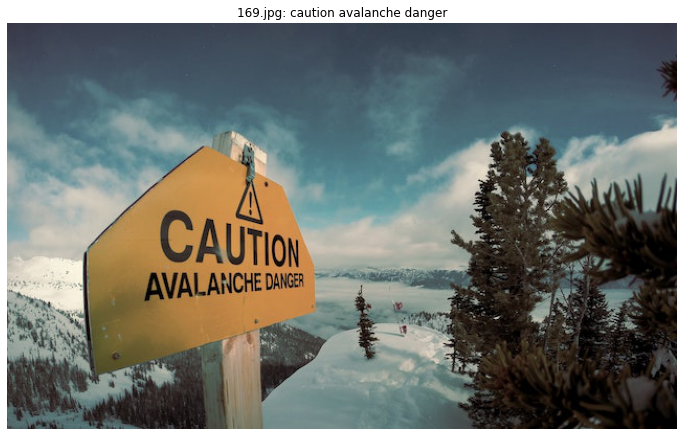

In [ ]:
task3_answer = '169.jpg'### YOUR ANSWER IN THE FORM of 'xxx.jpg'
plot_image(task3_answer, image_title=results_df.loc[task3_answer, 'text_in_image'])

In [ ]:
submit_your_answer(results_df, 'task3_res.json', task3_answer)

## <font color = '8B008B'> Tarea 4: Contar el número de caras en las imágenes </font>

Su gerente explica que las políticas de privacidad difieren para las imágenes que contienen rostros de personas.
Pero, lamentablemente, AnyCorp no tiene esa información disponible para cada imagen.

Su tarea es extraer el número de caras en cada imagen utilizando Amazon Rekognition y también encontrará una foto del "Monumento Nacional Monte Rushmore". Tu jefe lo necesita rápidamente y por lo que recuerda, no hay texto en esa imagen. Te da una pequeña lección de historia sobre el monumento y el hecho de que la escultura presenta las cabezas de cuatro presidentes de Estados Unidos. Tu trabajo es aprovechar Amazon API de Rekognition 'detect_faces' para contar rápidamente el número de caras en cada imagen.

### Tarea 4 Paso 1- Contar el número de caras:
Función "extract_num_faces": esta función utiliza la API "detect_faces" de Amazon Rekognition para extraer caras de una imagen. Una vez que tenga la respuesta de la API "detect_faces", cuente el número de elementos en la clave "FaceDetails". La función debería devolver el número de caras en una imagen.

In [ ]:
def extract_num_faces(bucket_name, image_key):

    client_faces = boto3.client('rekognition')
    response = client_faces.detect_faces(Image={'S3Object': {'Bucket': bucket_name,'Name': image_key}},Attributes=["ALL"])
    n_faces = len(response['FaceDetails'])# Extract from API Response

    return n_faces


In [ ]:
extract_num_faces(BUCKET_NAME, '100.jpg')

3

Number of faces found: 3


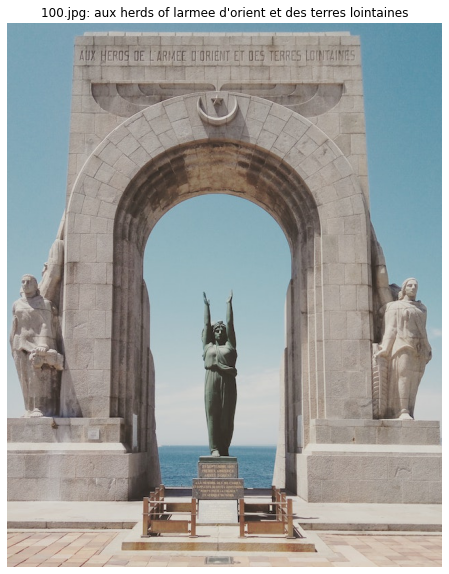

In [ ]:
## Ejemplo a la imagen # 100
sample_image = '100.jpg'
n_faces = extract_num_faces(BUCKET_NAME, sample_image)
print('Number of faces found: {}'.format(n_faces))
plot_image(sample_image, image_title=results_df.loc[sample_image, 'text_in_image'])

## Tarea 4 Paso 2: Complete la columna 'n_face' del marco de datos
Ejecutemos la función "extract_num_faces" en el texto de todas las imágenes. Extraerá el número de caras en todas las imágenes y rellenará las columnas 'n_faces'.

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    # Extract text from results_df
    text_in_image = row['text_in_image']
    try: 
        n_faces = extract_num_faces(BUCKET_NAME, key)
        results_df.loc[key, 'n_faces'] = n_faces
    except Exception as e:
        print(e)
        print('Face extraction analysis failed')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
processing image: 118.jpg
processing image: 119.jpg
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
processing image: 139.jpg
processing image: 141.jpg
processing image: 143.jpg
processing image: 144.jpg
processing image: 145.jpg
processing i

In [ ]:
results_df.head()

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,aux herds of larmee d'orient et des terres loi...,fr,0.51,NEUTRAL,0,0,0.99,0,3,NaN,NaN
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,home,en,1,NEUTRAL,0.01,0.01,0.97,0,1,NaN,NaN
102.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,102.jpg,you are beautiful,en,1,POSITIVE,0.99,0,0,0,0,NaN,NaN
103.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,103.jpg,all are welcome here. consentle,en,1,NEUTRAL,0.35,0.02,0.5,0.13,0,NaN,NaN
104.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,104.jpg,@@@@@@@@@@? work hard stay humble $ m w 1 f no...,en,0.86,NEUTRAL,0.01,0,0.99,0,0,NaN,NaN


### Tarea 4 Paso 3: ¡Encuentra la imagen con cuatro caras! 
Según la columna 'n_faces' de results_df, ¿qué imagen tiene cuatro caras?

In [ ]:
results_df.sort_values(by=['n_faces'], ascending=False)

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
143.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,143.jpg,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,aux herds of larmee d'orient et des terres loi...,fr,0.51,NEUTRAL,0,0,0.99,0,3,NaN,NaN
165.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,165.jpg,leonardo,en,0.35,NEUTRAL,0.01,0,0.99,0,2,NaN,NaN
185.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,185.jpg,this is a neighbourhood area watch are,en,1,NEUTRAL,0.04,0.01,0.95,0,1,NaN,NaN
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,home,en,1,NEUTRAL,0.01,0.01,0.97,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,136.jpg,+ 824-741 st 4 city of perth hay cirv of perth,en,0.94,NEUTRAL,0,0,1,0,0,NaN,NaN
135.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,135.jpg,libeouse oht!!,en,0.51,NEUTRAL,0.35,0.08,0.45,0.12,0,NaN,NaN
134.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,134.jpg,notruf,de,0.74,NEUTRAL,0.01,0.03,0.96,0,0,NaN,NaN
133.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,133.jpg,do what you love,en,0.99,POSITIVE,0.86,0.01,0.1,0.03,0,NaN,NaN


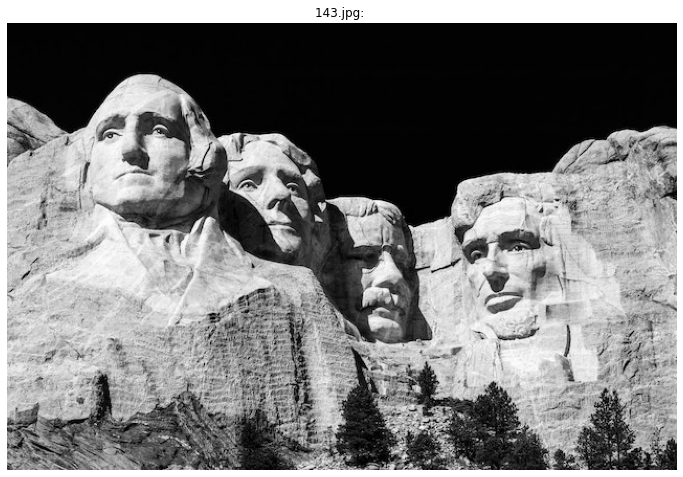

In [ ]:
task4_answer = '143.jpg'
plot_image(task4_answer, image_title='')

In [ ]:
submit_your_answer(results_df, 'task4_res.json', task4_answer)

## <font color = '8B008B'> Tarea 5: ¡Etiquete las imágenes con la API 'detect_labels' de Amazon Rekognition! </font>

Ahora es tu turno de sorprender a tu gerente. Crees ella quedará impresionada si puedes extraer la etiqueta de todas las imágenes ¡automáticamente!
Etiquete todas las imágenes con Amazon Rekognition API "detect_labels". Esta API analiza un imagen y devuelve etiquetas junto con sus puntuación de confianza asociada.



### Tarea 5 Paso 1- Encuentre etiquetas de imagen:
Función 'extract_image_labels': esta función utiliza la API 'detect_labels' de Amazon Rekognition para extraer etiquetas de una imagen. Una vez que tenga la respuesta de la API 'detect_labels', extraiga la etiqueta superior y la puntuación de confianza asociada. La función debería devolver estos dos valores.

In [ ]:
def extract_image_labels(bucket_name, image_key):
    client_labels = boto3.client('rekognition')
    response = client_labels.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucket_name,
            'Name': image_key,
        }
    },
    MaxLabels=123,
)
    label = response['Labels'][0]['Name']# Extract from API response
    label_conf = response['Labels'][0]['Confidence']# Extract from API response
        
    return(label,label_conf)

Automatically labeled as: ('Road Sign', 99.79357147216797)


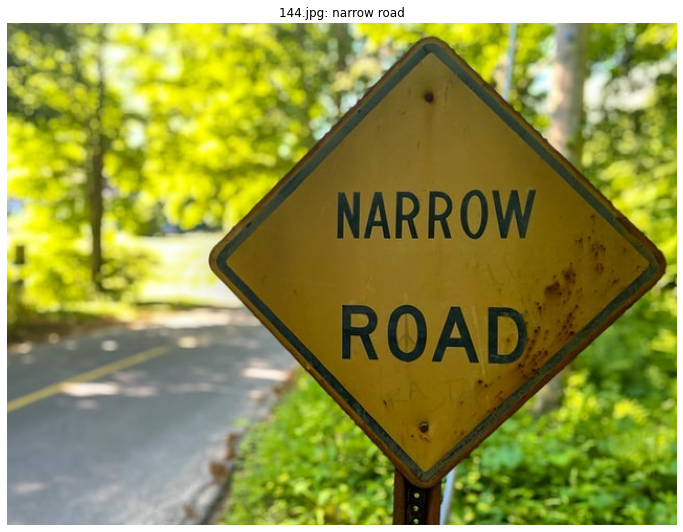

In [ ]:
## Ejemplo d eejecución
sample_image = '144.jpg'
label = extract_image_labels(BUCKET_NAME, sample_image)
print('Automatically labeled as: {}'.format(label))
plot_image(sample_image, image_title=results_df.loc[sample_image, 'text_in_image'])

## Tarea 5 Paso 2: Complete las columnas 'label' y 'label_score' del marco de datos
Ejecutemos la función "extract_image_labels" en el texto de todas las imágenes. Extraerá la etiqueta y la puntuación de confianza en todas las imágenes y completará las columnas 'label' y 'label_conf'. Todas las columnas deben llenarse en este punto.

In [ ]:
for i, (key, row) in enumerate(results_df.iterrows()):
    print('processing image: {}'.format(key))

    try: 
        label, label_conf = extract_image_labels(BUCKET_NAME, key)
        results_df.loc[key, 'label'] = label
        results_df.loc[key, 'label_conf'] = label_conf
    except Exception as e:
        print(e)
        print('Unable to do label analysis')
        pass

processing image: 100.jpg
processing image: 101.jpg
processing image: 102.jpg
processing image: 103.jpg
processing image: 104.jpg
processing image: 105.jpg
processing image: 106.jpg
processing image: 107.jpg
processing image: 108.jpg
processing image: 109.jpg
processing image: 110.jpg
processing image: 111.jpg
processing image: 112.jpg
processing image: 117.jpg
processing image: 118.jpg
processing image: 119.jpg
processing image: 122.jpg
processing image: 123.jpg
processing image: 124.jpg
processing image: 125.jpg
processing image: 126.jpg
processing image: 127.jpg
processing image: 128.jpg
processing image: 129.jpg
processing image: 130.jpg
processing image: 131.jpg
processing image: 132.jpg
processing image: 133.jpg
processing image: 134.jpg
processing image: 135.jpg
processing image: 136.jpg
processing image: 137.jpg
processing image: 138.jpg
processing image: 139.jpg
processing image: 141.jpg
processing image: 143.jpg
processing image: 144.jpg
processing image: 145.jpg
processing i

In [ ]:
results_df.head()

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
100.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,100.jpg,aux herds of larmee d'orient et des terres loi...,fr,0.51,NEUTRAL,0,0,0.99,0,3,Monument,99.9853
101.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,101.jpg,home,en,1,NEUTRAL,0.01,0.01,0.97,0,1,Monument,99.6775
102.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,102.jpg,you are beautiful,en,1,POSITIVE,0.99,0,0,0,0,Label,100
103.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,103.jpg,all are welcome here. consentle,en,1,NEUTRAL,0.35,0.02,0.5,0.13,0,Label,100
104.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,104.jpg,@@@@@@@@@@? work hard stay humble $ m w 1 f no...,en,0.86,NEUTRAL,0.01,0,0.99,0,0,Text,99.9974


### Tarea 5 Paso 3: ¡Encuentra la imagen que contiene un pájaro!
¡Ahora debería encontrar la imagen que contiene un pájaro! Según la columna 'etiqueta' de results_df, ¿qué imagen está etiquetada como 'pájaro' o 'animal'?

In [ ]:
results_df.sort_values(by=['label'])

,bucket_name,image_key,text_in_image,dominant_language_code,dominant_language_score,sentiment,sentiment_positive_score,sentiment_negative_score,sentiment_neutral_score,sentiment_mixed_score,n_faces,label,label_conf
195.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,195.jpg,covid-19 mask required please do not enter wit...,en,0.59,NEUTRAL,0.01,0.04,0.95,0,0,Advertisement,98.6667
141.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,141.jpg,a,en,0.89,NEUTRAL,0.02,0.02,0.92,0.03,0,Architecture,98.793
156.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,156.jpg,beware dangerous cliffs,en,0.97,NEGATIVE,0,0.83,0.16,0,0,Bird,98.8894
136.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,136.jpg,+ 824-741 st 4 city of perth hay cirv of perth,en,0.94,NEUTRAL,0,0,1,0,0,Brick,94.9241
177.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,177.jpg,"templewood, avenue nw3.",en,0.33,NEUTRAL,0,0,1,0,0,Brick,99.9995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,130.jpg,"to fabulous las vegas <motor nevada <<yelee. """,en,0.88,POSITIVE,0.76,0.01,0.2,0.03,0,Tree,93.7058
138.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,138.jpg,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Villa,99.8967
150.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,150.jpg,autour chapelle de la mathieu creations bijoux...,fr,0.76,NEUTRAL,0,0,1,0,0,Walkway,98.7669
194.jpg,labstack-prewarm-8242fc2b-4780-436f-8c-readima...,194.jpg,no smoking hoituad,gl,0.4,NaN,NaN,NaN,NaN,NaN,0,Wheel,96.6387


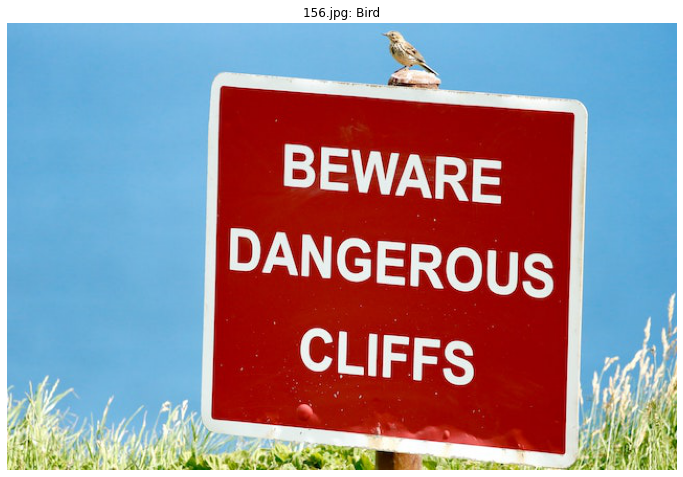

In [ ]:
plot_image(task5_answer, image_title=results_df.loc[task5_answer, 'label'])

## ¡Felicidades! ¡Ya has completado este desafío!